In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from tabulate import tabulate
import mlflow
from sklearn.linear_model import SGDRegressor


path = 'datasets/LEAF_LEVEL_DATASET_Yufeng_Ge.xlsx'

# Read and load dataset
df= pd.read_excel(path, sheet_name=[0, 1])


INPUT DATA

In [2]:
X =df.get(0)
X = (X.iloc[:,14:]).values
print(X.shape)

(2905, 2151)


OUTPUT DATA

In [3]:
Y =df.get(0)
Y = (Y.iloc[:,7]).values
print(Y.shape)

(2905,)


**LINEAR REGRESSION with SVD**

2024/07/07 17:31:20 INFO mlflow.tracking.fluent: Experiment with name 'Linear SVD Nitrogen Demetra' does not exist. Creating a new experiment.


Ripartion: 0.05
Ripartion: 0.1
Ripartion: 0.15
Ripartion: 0.2
Ripartion: 0.25
Ripartion: 0.3
Ripartion: 0.35
Ripartion: 0.4
Ripartion: 0.45
Ripartion: 0.5
╔════════════════╦══════════════╦══════════════╦══════════════════╦═════════╗
║   Test size(%) ║   Best(MSE1) ║   Mean(MSE1) ║        Var(MSE1) ║   Seed1 ║
╠════════════════╬══════════════╬══════════════╬══════════════════╬═════════╣
║              5 ║     0.299066 ║   1029.5     ║ 617627           ║      79 ║
║             10 ║    95.772    ║   1227.85    ║ 431426           ║      79 ║
║             15 ║   323.74     ║   1734.72    ║ 693810           ║      87 ║
║             20 ║   910.287    ║   3746.09    ║      3.24808e+06 ║      90 ║
║             25 ║  6760.97     ║  29103.1     ║      3.23375e+08 ║      87 ║
║             30 ║   331.709    ║   1032.23    ║ 315342           ║      72 ║
║             35 ║    17.5811   ║     50.8269  ║    476.372       ║      54 ║
║             40 ║     3.61537  ║      6.91395 ║      8.38436    

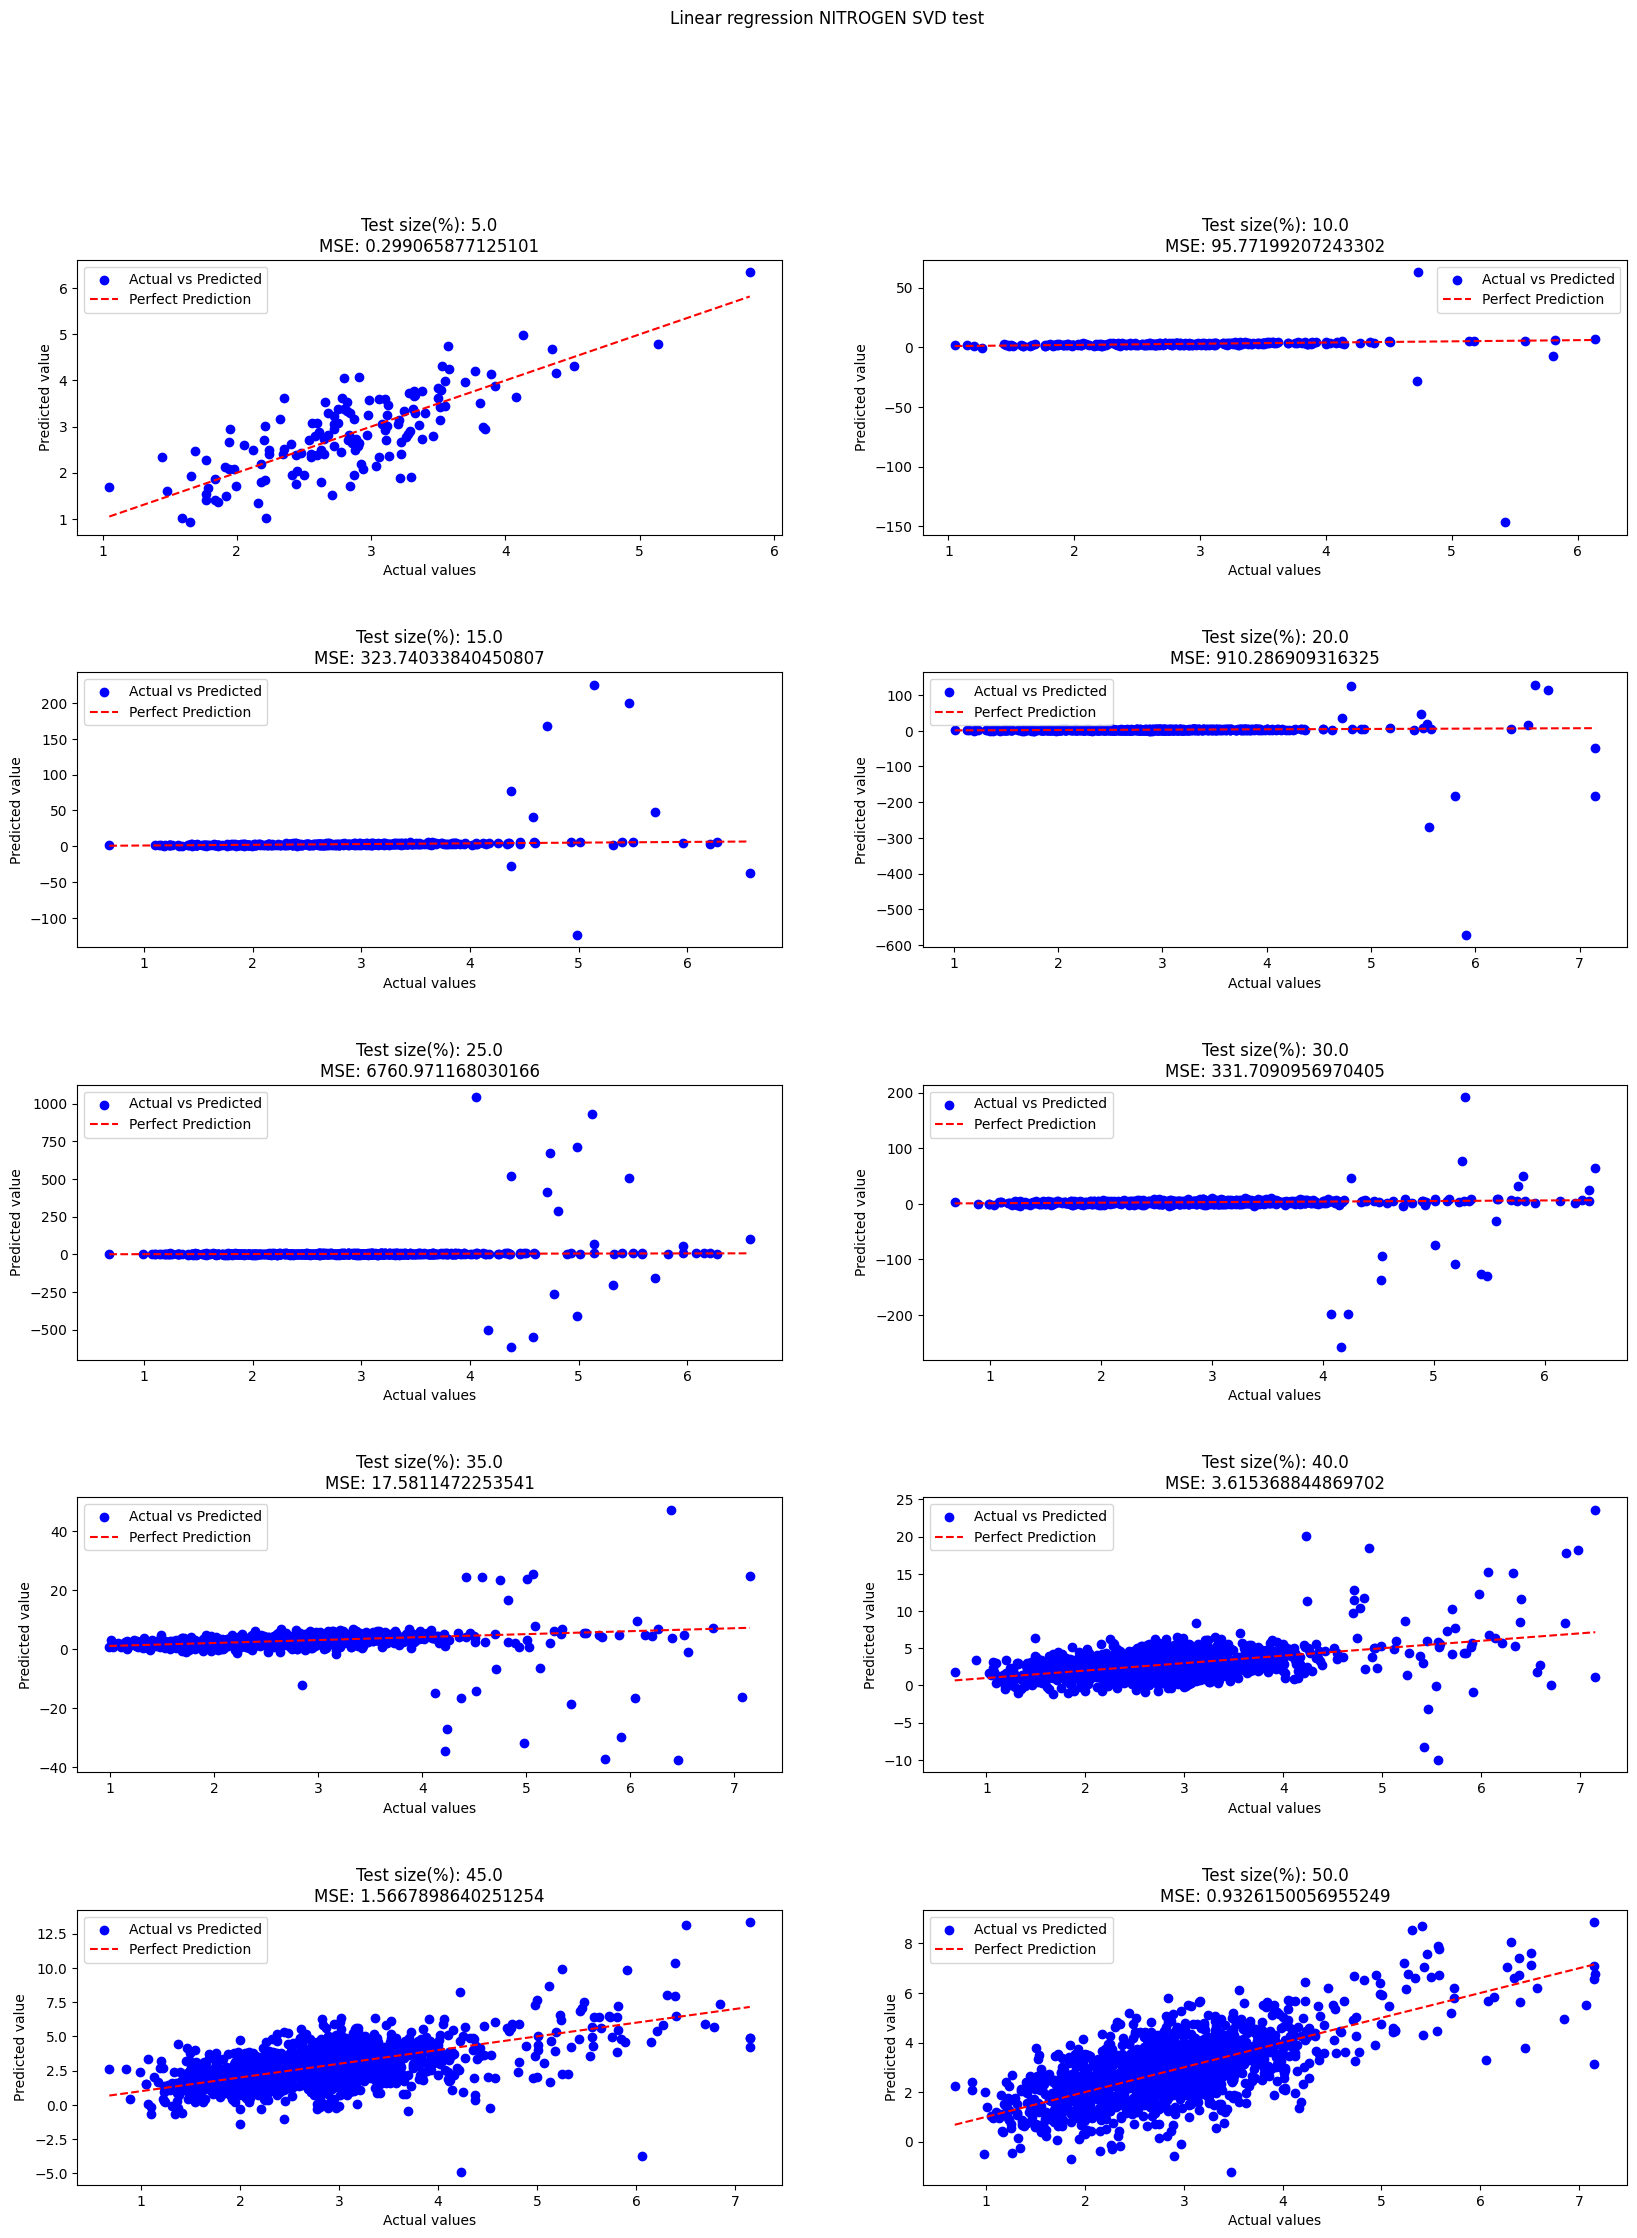

In [27]:

mlflow.set_experiment("Linear SVD Nitrogen Demetra")
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartitions = [i/100 for i in range(5,55,5)]
results = [] 

# create 5x2 subfigs
fig, axs = plt.subplots(5, 2,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Linear regression NITROGEN SVD test')
axs = axs.flatten()
k = 0

for ripartition in ripartitions:

    '''nitrogen'''
    MSE_param1 = []
    best_MSE_1 = 100000000
    best_data_1 = {"Y_test":None, "Y_pred":None,"seed":None}
    
    run_name = str(ripartition) + " ripartition"
    with mlflow.start_run(run_name=run_name):

        print("Ripartion: " + str(ripartition))
        mlflow.log_param('ripartition', ripartition)
        for i in range(trials):
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
            regr = LinearRegression()
    
            # Train the model using the training sets
            regr.fit(X_train, Y_train)
    
            # Make predictions using the testing set
            Y_pred_regr_svd = regr.predict(X_test)
    
            #save MSE of the first parameters
            MSE_param1.append(mean_squared_error(Y_test, Y_pred_regr_svd))
    
            #check if this is the best model in terms of MSE
            if MSE_param1[-1] < best_MSE_1:
              best_MSE_1 = MSE_param1[-1]
              best_data_1["Y_test"] = Y_test
              best_data_1["Y_pred"] = Y_pred_regr_svd
              best_data_1["seed"] = seeds[i]


                
        mlflow.log_metric("Best_MSE1", best_MSE_1)
        mlflow.log_metric("Mean_MSE1", np.mean(MSE_param1))
        mlflow.log_metric("Var_MSE1", np.var(MSE_param1))
        
    results.append([str(ripartition * 100), str(best_MSE_1),
                    (np.mean(MSE_param1)), str(np.var(MSE_param1)),
                    best_data_1["seed"]])
    
    '''PLOT THE BEST MODELS'''
    axs[k].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
    axs[k].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
    axs[k].legend()
    axs[k].set_xlabel("Actual values")
    axs[k].set_ylabel("Predicted value")
    axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "MSE: " + str(min(MSE_param1)) )
    k += 1

'''SHOW RESULTS'''

headers = ["Test size(%)", "Best(MSE1)", "Mean(MSE1)", "Var(MSE1)","Seed1"]

print(tabulate(results, headers,  tablefmt="double_outline"))


**LINEAR REGRESSION with SGD**

2024/07/07 17:44:36 INFO mlflow.tracking.fluent: Experiment with name 'Linear SGD NITROGEN Demetra' does not exist. Creating a new experiment.


Ripartion: 0.05
Ripartion: 0.1
Ripartion: 0.15
Ripartion: 0.2
Ripartion: 0.25
Ripartion: 0.3
Ripartion: 0.35
Ripartion: 0.4
Ripartion: 0.45
Ripartion: 0.5
╔════════════════╦══════════════╦══════════════╦═════════════╦═════════╗
║   Test size(%) ║   Best(MSE1) ║   Mean(MSE1) ║   Var(MSE1) ║   Seed1 ║
╠════════════════╬══════════════╬══════════════╬═════════════╬═════════╣
║              5 ║     0.244723 ║     0.379091 ║  0.0030191  ║      37 ║
║             10 ║     0.317269 ║     0.398073 ║  0.0020652  ║       1 ║
║             15 ║     0.338074 ║     0.402231 ║  0.00184166 ║      39 ║
║             20 ║     0.335525 ║     0.410043 ║  0.00175304 ║      52 ║
║             25 ║     0.35298  ║     0.413469 ║  0.00115394 ║      86 ║
║             30 ║     0.343483 ║     0.41394  ║  0.00136584 ║      81 ║
║             35 ║     0.35917  ║     0.421968 ║  0.00154311 ║      86 ║
║             40 ║     0.358324 ║     0.426165 ║  0.00158235 ║      33 ║
║             45 ║     0.356921 ║     0.43

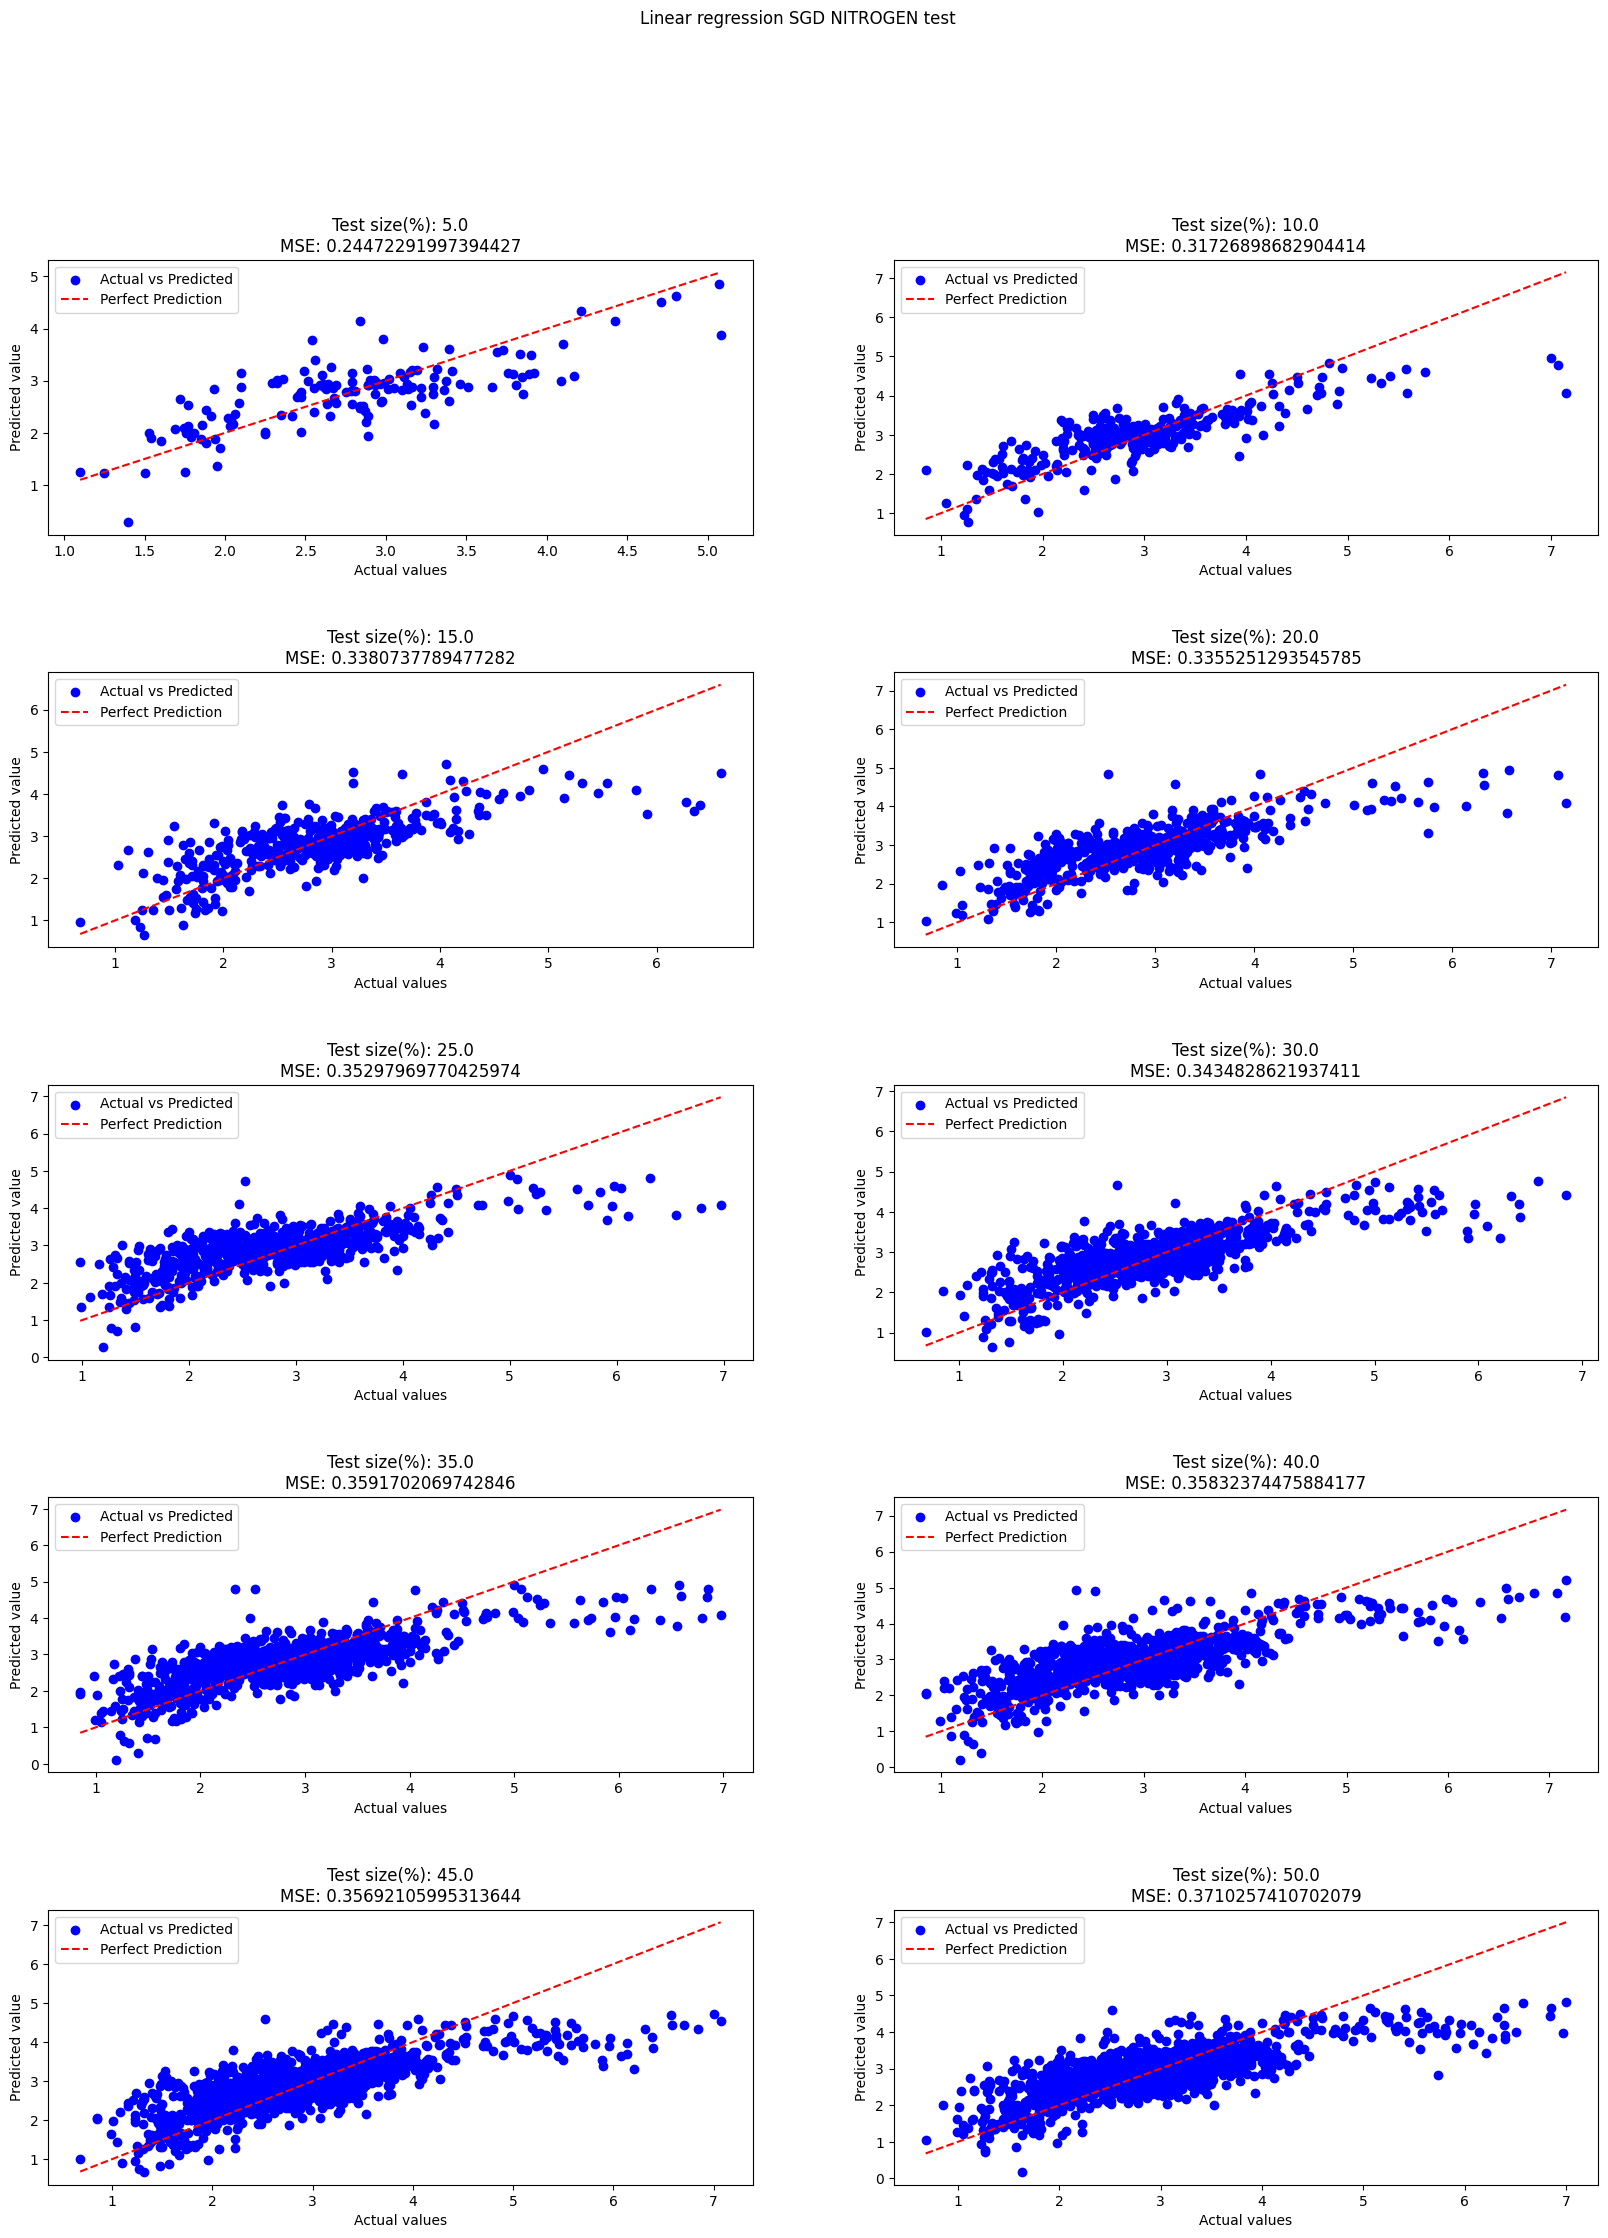

In [28]:

mlflow.set_experiment("Linear SGD NITROGEN Demetra")
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartitions = [i/100 for i in range(5,55,5)]
results = [] 

# create 5x2 subfigs
fig, axs = plt.subplots(5, 2,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Linear regression SGD NITROGEN test'+"\n")
axs = axs.flatten()
k = 0

for ripartition in ripartitions:

    '''PARAM 1'''
    MSE_param1 = []
    best_MSE_1 = 100000000
    best_data_1 = {"Y_test":None, "Y_pred":None,"seed":None}


    run_name = str(ripartition) + " ripartition"
    with mlflow.start_run(run_name=run_name):
        print("Ripartion: " + str(ripartition))
        mlflow.log_param('ripartition', ripartition)
        for i in range(trials):
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=seeds[i])
            sgd_reg = SGDRegressor(max_iter=5000, tol=1e-5, penalty=None, eta0=0.01,
            n_iter_no_change=10, random_state=42)
    
            # Train the model using the training sets
            sgd_reg.fit(X_train, Y_train)
    
            # Make predictions using the testing set
            Y_pred_regr_sgd = sgd_reg.predict(X_test)
    
            #save MSE of the first parameters
            MSE_param1.append(mean_squared_error(Y_test, Y_pred_regr_sgd))
    
            #check if this is the best model in terms of MSE
            if MSE_param1[-1] < best_MSE_1:
              best_MSE_1 = MSE_param1[-1]
              best_data_1["Y_test"] = Y_test
              best_data_1["Y_pred"] = Y_pred_regr_sgd
              best_data_1["seed"] = seeds[i]
    
        mlflow.log_metric("Best_MSE1", best_MSE_1)
        mlflow.log_metric("Mean_MSE1", np.mean(MSE_param1))
        mlflow.log_metric("Var_MSE1", np.var(MSE_param1))
        
    results.append([str(ripartition * 100), str(best_MSE_1),
                    (np.mean(MSE_param1)), str(np.var(MSE_param1)),
                    best_data_1["seed"]])
    
    '''PLOT THE BEST MODELS'''
    axs[k].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
    axs[k].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
    axs[k].set_title("Best MSE results" + "\n" + f"Test size(%): {ripartition * 100}")
    axs[k].legend()
    axs[k].set_xlabel("Actual values")
    axs[k].set_ylabel("Predicted value")
    axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "MSE: " + str(min(MSE_param1)) )
    k += 1


'''SHOW RESULTS'''

headers = ["Test size(%)", "Best(MSE1)", "Mean(MSE1)", "Var(MSE1)","Seed1"]

print(tabulate(results, headers,  tablefmt="double_outline"))
